In [30]:
from google.colab import data_table

In [100]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

import seaborn as sns
import matplotlib.pyplot as plt

In [161]:
data, X_test = pd.read_csv("train.csv"), pd.read_csv("test.csv")

## Exploratory Data Analysis

En résumé : 
- les données sont issues d'un sondage sur des personnes vivant en France
  - on les classe en groupes en fonction de leurs réponses à certaines questions concernant notamment leurs goûts et habitudes alimentaires en matière de fruits et légumes
- les données sont catégorielles
- beaucoup de données sont manquantes (comme on peut s'y attendre s'il s'agit bien d'un sondage)
- il y a 4 groupes de tailles inégales

In [33]:
data_table.DataTable(data.head(500), include_index=False, num_rows_per_page=10, max_columns= 25)

,id,AP,creation_date_answer,situation,ctc,location,gc_id,gc_label,creation_date_global,id_group,...,fruits_or_vegetables,number_of_fruit,id_group_3,creation_date_request,hobby,id_group_4,ville,green_vegetables,vegetable_type,target
0,a46cfa61ea20a,f,2019-03-13 11:14:42.549,-1,NaN,52,70,G,2019-01-17 10:50:57.767,2d7e206d46ea1,...,NaN,-1,812a43d710ace,2019-03-13 11:14:42.549,football,aa8f4934a31eb,NaN,f,NaN,0
1,c3d0cb8f0c5e2,f,2019-03-21 14:27:32.441,-1,NaN,78,10,A,2018-08-20 05:57:51.038,35e96d6848871,...,NaN,-1,4b59257f24573,2019-03-21 14:27:32.441,football,6ff9ea9ec85fd,NaN,f,NaN,1
2,05dfbe0ec3a8b,f,2019-03-15 17:49:50.67,-1,NaN,70,10,A,2018-12-20 13:45:51.752,ffaf8085e383d,...,NaN,-1,f1a838f0d194b,2019-03-15 17:49:50.67,football,6a49a0a97b049,NaN,f,NaN,0
3,952e869ee1076,f,2019-01-07 08:19:29.114,-1,f,84,10,A,2018-07-21 10:28:49.386,5360cf0a40ce3,...,NaN,0,c3196847d1c14,2019-01-07 08:19:29.114,football,d0dcf1ca1bf04,NaN,f,NaN,1
4,5bd0e71b1395b,f,2019-02-03 17:57:22.926,-1,NaN,29,20,D,2018-12-07 19:59:26.968,126c3211f23fc,...,NaN,-1,70e18c6fe58cd,2019-02-03 17:57:22.926,football,b4870b1c8eb42,NaN,f,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1794a4846fa30,f,2019-01-11 20:44:35.052,-1,f,70,10,A,2018-03-19 13:53:34.149,0ffa047ed5a61,...,NaN,0,fca8f58f95b76,2019-01-11 20:44:35.052,football,3be7561c31a09,Lyon,f,NaN,0
496,8f71ebbf9509f,f,2019-03-27 09:00:32.464,-1,NaN,69,20,D,2017-03-16 00:00:00.000,fa10cafd76c34,...,NaN,-1,ebb1d98ce2a9c,2019-03-27 09:00:32.464,football,686b422224c51,NaN,f,NaN,1
497,89b754193deb9,f,2019-03-04 11:14:39.83,-1,t,95,40,B,2019-01-08 09:12:50.034,30c9ef7739df2,...,t,1,79aa2c96bd0fc,2019-03-04 11:14:39.83,football,fb5da4fd2df22,Orly,f,NaN,0
498,ddde34390f253,f,2019-02-11 07:36:59.767,-1,f,60,20,D,2019-02-07 11:11:06.577,ef4e280a5b538,...,f,0,43fb923ca45ed,2019-02-11 07:36:59.767,football,1910273fcfab1,NaN,f,NaN,0


#### Equilibre de classes

Déséquilibre entre les classes : la classe majoritaire 0 possède 12,000 représentant, contre 233 pour la classe minoritaire 3. On en prendra compte lors de la classification à l'aide d'un fonction de coût personnalisée

In [34]:
print(data.groupby("target")["id"].count())

target
0    12077
1     8816
2     3874
3      233
Name: id, dtype: int64


#### Position

Les données de position ne semblent pas correspondre à un code de département par exemple.

In [ ]:
data["location"].unique()

array([    52,     78,     70,     84,     29,     32,     96,     43,
           50,     47,      3,     60,     68,     95,      8,     34,
           93,     92,     45,     87,     14,     22,     33, 315670,
           51,     81,     36,    100,     69,     54,     39,     75,
       315710,     13,     10,     94,     80,     64,     58,     27,
            6,     88,     11,     18,     67,     89,     83,     26,
           38,     63,     35,     17,     73,     46,     61,     37,
           79,     99,     59,     72,      2,     16,     55,     71,
           15,     86,     53,     30,     28,     12,     66,     23,
           91,     57,     41,     74,     90,    101,     40,     31,
           25,      1,     85,     24,     97,     62,     82,      7,
           44,     56,     42,      4, 314550,     98,      9,     19,
           49,     21,      5])

#### Réponse, requête position

Notons que parfois la réponse est créée avant la requête

In [120]:
data[data["creation_date_request"] > data["creation_date_answer"]]

,id,AP,creation_date_answer,situation,ctc,location,gc_id,gc_label,creation_date_global,id_group,...,fruit_situation_id,fruit_situation_label,fruits_or_vegetables,number_of_fruit,id_group_3,creation_date_request,hobby,id_group_4,green_vegetables,target
6568,faa9249df77a9,f,2019-01-11 23:00:00,NaN,NaN,95,100,H,2018-10-23 22:00:58.091,2c3dd6e0be527,...,50,hetz,NaN,NaN,ff942c5351f53,2019-01-12 16:06:51.4,football,e0c9e8afe6c47,f,2
7684,6e7e1efb09000,f,2019-02-05 23:00:00,NaN,NaN,83,10,A,2019-02-05 19:42:43.397,5ffd853fe5980,...,10,ae,NaN,NaN,853e6668bc5e8,2019-02-06 23:30:00,football,3c6b02f97ebec,f,0
18943,7e99f3556a34d,f,2019-01-25 23:00:00,NaN,NaN,64,10,A,2018-11-27 11:16:48.356,c12d62fafad55,...,200,ag,NaN,NaN,a7745a77a32c3,2019-01-27 06:07:36.634,football,e8b041207bc4e,f,1
20367,01a51a1513ddc,f,2019-01-10 23:00:00,NaN,NaN,85,10,A,2019-01-13 20:14:07.172,b3b607bf034b8,...,200,ag,NaN,NaN,92218fb6e3652,2019-01-13 20:13:31.41,noball,2c467ce8951f5,f,1
22930,5d92580ed0c6e,f,2019-03-24 23:00:00,NaN,NaN,60,10,A,2019-02-12 08:45:39.146,7419f892a1501,...,200,ag,NaN,NaN,ce95b0f1b5e1a,2019-03-26 09:15:27.987,football,9d17f47dcd13d,f,1


#### Données manquantes

La plupart des valeurs du type de légume 

<Figure size 720x432 with 0 Axes>

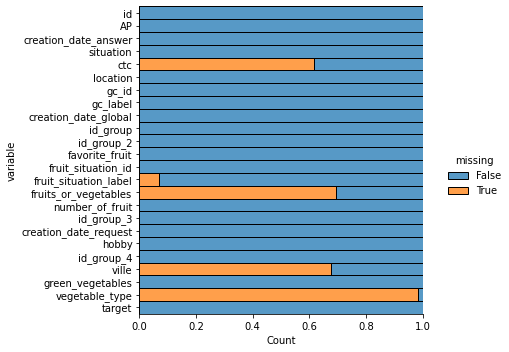

In [35]:
plt.figure(figsize=(10,6))
sns.displot(
    data=data.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)

In [36]:
print("Pourcentage de données manquantes dans number_of_fruit: {:.2f}%".format(100*data[data["number_of_fruit"] == -1]["number_of_fruit"].count()/ len(data)))
print("Pourcentage de données manquantes dans situation: {:.2f}%".format(100*data[data["situation"] == -1]["situation"].count()/ len(data)))

Pourcentage de données manquantes dans number_of_fruit: 71.67%
Pourcentage de données manquantes dans situation: 95.86%


#### Approche #1 Supprimer les lignes avec données manquantes

Une première approche pour gérer les données manquantes est de ne conserver que les lignes pour lesquelles on a toutes les données. Comme il n'y a que 27 lignes sans données manquantes, et qu'on ne peut pas entraîner de modèle sur si peu de données cette approche n'est pas la bonne.

In [37]:
data[(data["situation"] != -1) & (data["number_of_fruit"] != -1) & (~data["ville"].isna()) & (~data["fruits_or_vegetables"].isna()) & (~data["ctc"].isna()) & (~data["fruit_situation_label"].isna()) & (~data["vegetable_type"].isna())]

,id,AP,creation_date_answer,situation,ctc,location,gc_id,gc_label,creation_date_global,id_group,...,fruits_or_vegetables,number_of_fruit,id_group_3,creation_date_request,hobby,id_group_4,ville,green_vegetables,vegetable_type,target
457,d8952aa9b0ea8,f,2019-03-01 08:14:32.947,10,f,96,40,B,2018-12-07 15:07:21.410,ba3dfd614e269,...,t,2,473056069a2ca,2019-03-01 08:14:32.947,football,bc20cc2f077c3,Soisy-sous-Montmorency,t,green,0
556,8e3861d91c51e,f,2019-03-20 16:12:33.055,10,f,39,40,B,2018-06-06 12:42:12.904,7c18496e7bbf1,...,f,3,e2dd34313d972,2019-03-20 16:12:33.055,football,258a9f6c31267,Les Abrets,t,salad,0
822,c2b1110877842,f,2019-03-05 11:43:04.59,10,f,92,40,B,2018-10-29 12:28:37.204,f38c305a92068,...,f,3,14b7f1d8a1adb,2019-03-05 11:43:04.59,football,e2839933d95e0,Corbeil-Essonnes,t,salad,2
3401,0d6cf4aa04079,f,2019-02-13 12:08:46.372,10,f,95,40,B,2018-11-02 11:50:11.824,a3fda66ff824c,...,f,1,79aa2c96bd0fc,2019-02-13 12:08:46.372,football,2c48e31812e4b,Périgny,t,salad,2
3550,18a4a29b35260,f,2019-03-30 10:06:21.561,40,f,39,40,B,2019-01-30 11:13:50.820,a8d8603f88696,...,t,1,3e9e4035260ee,2019-03-30 10:06:21.561,football,6649cf833aa30,Bourgoin-Jallieu,t,green,0
3965,4edf4470f9338,f,2019-03-08 11:11:51.026,40,f,57,20,D,2017-11-23 08:21:16.281,b935efc0660e9,...,f,0,3f34584d663c2,2019-03-08 11:11:51.026,volleyball,f3f3ee814ac81,Rennes,t,green,0
5970,1f70617c7a2b9,f,2019-03-11 10:49:08.114,10,t,39,40,B,2019-02-21 09:47:16.853,41100dd116bb1,...,f,2,c4fd5f6362013,2019-03-11 10:49:08.114,football,698369025b33d,Saint-Martin-d'Hères,t,prettygreen,1
6320,ff3209650db01,f,2019-01-28 16:40:28.832,40,f,79,20,D,2019-01-27 08:58:21.970,bb6ef4dc77d32,...,f,0,68251b4b87cea,2019-01-28 16:40:28.832,football,ea61bf16c45ae,Rosny-sur-Seine,t,salad,2
10302,b1503ec393ba8,f,2019-02-07 07:39:49.164,40,f,79,20,D,2019-01-27 08:58:21.970,bb6ef4dc77d32,...,f,0,6333b3a68500f,2019-02-07 07:39:49.164,football,ea61bf16c45ae,Rosny-sur-Seine,t,salad,1
10322,4d1ae9f0a36ed,f,2019-01-17 17:00:00,20,f,80,40,B,2019-01-18 13:27:25.924,b5508988fae5d,...,t,4,a7945b8a7db20,2019-01-17 17:00:00,football,07539919f1d4f,Chizé,t,salad,1


#### Approche #2 Supprimer certaines colonnes, puis les lignes avec données manquantes

On supprime les colonnes avec les données manquantes qui semblent peu importantes. Puis on conserve les lignes. Cette méthode a le désavantage d'être assez arbitraire et ville. Les colonnes qui me semblent les moins pertinentes sont: vegetable type (étant donné le peu de données que l'on a dessus.

Les résultats ne sont pas bien meilleurs, on ne peut pas entraîner un modèle performant sur si peu de données.

In [38]:
data = data[data.columns.drop({"ville", "vegetable_type"})]
data[(data["situation"] != -1) & (data["number_of_fruit"] != -1) & (~data["fruits_or_vegetables"].isna()) & (~data["ctc"].isna()) & (~data["fruit_situation_label"].isna())]

,id,AP,creation_date_answer,situation,ctc,location,gc_id,gc_label,creation_date_global,id_group,...,fruit_situation_id,fruit_situation_label,fruits_or_vegetables,number_of_fruit,id_group_3,creation_date_request,hobby,id_group_4,green_vegetables,target
40,42db38006a7df,f,2019-02-13 09:31:36.033,10,f,92,100,H,2018-10-30 12:34:47.572,dab58eb0f4631,...,50,hetz,f,1,bdfb514b136fc,2019-02-13 09:31:36.033,football,3bc4647ec5d8e,f,2
98,08d40a42eb3f8,f,2019-03-08 13:28:17.821,20,f,39,40,B,2019-03-08 13:36:12.436,a645eddff8d5a,...,120,jzy,f,4,c4fd5f6362013,2019-03-08 13:28:17.821,football,7ef32c6e60f6f,f,0
120,c842e530269dc,f,2019-01-24 11:35:51.316,10,f,17,40,B,2018-12-05 11:01:05.696,df404e6e88c8b,...,50,hetz,f,1,5c60b19cc7164,2019-01-24 11:35:51.316,football,887beb2274ecc,f,2
206,ddbfbafaae63c,f,2019-03-03 08:59:40.483,10,f,39,100,H,2019-02-06 07:59:43.635,d4b853e3a2eec,...,160,zht,f,3,3e9e4035260ee,2019-03-03 08:59:40.483,football,f51f458d7a342,f,0
296,a444caea60a34,f,2019-02-12 11:26:20.533,10,f,96,40,B,2019-01-23 11:57:47.266,448a59add9be4,...,200,ag,t,1,e90a68d1b76bc,2019-02-12 11:26:20.533,football,d6cb31d7b4419,f,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24858,960a91c297ebf,f,2019-02-28 08:54:23.837,10,f,95,100,H,2018-10-02 12:17:04.557,0c83821177a08,...,200,ag,f,2,09150410ddc38,2019-02-28 08:54:23.837,football,7bdc638b9a292,f,0
24898,6c457e0af11a5,f,2019-03-08 08:47:25.891,10,t,28,40,B,2019-03-04 16:39:31.029,e0ec87494752c,...,200,ag,f,1,9573e14bc0278,2019-03-08 08:47:25.891,football,8cc34bcb71e52,f,0
24957,1c72cde1ccee9,f,2019-01-08 16:47:29.324,10,f,39,100,H,2018-11-03 16:19:20.955,c5f857368e683,...,200,ag,f,1,e93cce89945c2,2019-01-08 16:47:29.324,football,f51feb91c5642,f,0
24961,f467a5e52146a,f,2019-03-27 14:51:30.451,10,f,93,40,B,2018-09-27 15:18:22.910,7480a38181c5d,...,50,hetz,f,1,0017351a2c258,2019-03-27 14:51:30.451,football,2b8dce05d7ad2,f,2


#### Approche #3 Traiter les données manquantes comme de nouvelles catégories (Imputation).

Les données manquantes ne concernent que les données catégorielles. On va utiliser une stratégie d'imputation pour gérer ces données. Ca semble déjà avoir été fait pour les colonnes avec des valeurs numériques (situation, nombre de fruits par exemple). On garde le même standard. Cette approche est celle que l'on va conserver dans la suite.

In [39]:
data = data.replace(-1, np.nan)

## Feature Selection and Engineering

On commence par retirer certaines colonnes qui ne serviront pas à la classification. 
Puis on encode les données catégorielles pour pouvoir donner la matrice de caractéristiques en entrée du classifieur.

In [147]:
columns_to_drop = {"id", 
                   "creation_date_answer",
                   "creation_date_request",
                   "id_group", 
                   "id_group_2", 
                   "id_group_3",
                   "id_group_4",
                   "creation_date_global", 
                   "target"}
new_columns = data.columns.drop(columns_to_drop)

,AP,situation,ctc,location,gc_id,gc_label,favorite_fruit,fruit_situation_id,fruit_situation_label,fruits_or_vegetables,number_of_fruit,hobby,ville,green_vegetables,vegetable_type
0,f,-1,NaN,52,70,G,poire,120,jzy,NaN,-1,football,NaN,f,NaN
1,f,-1,NaN,78,10,A,clementine,10,ae,NaN,-1,football,NaN,f,NaN
2,f,-1,NaN,70,10,A,clementine,200,ag,NaN,-1,football,NaN,f,NaN
3,f,-1,f,84,10,A,clementine,10,ae,NaN,0,football,NaN,f,NaN
4,f,-1,NaN,29,20,D,clementine,10,ae,NaN,-1,football,NaN,f,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,f,-1,NaN,17,10,A,clementine,160,zht,NaN,-1,football,NaN,f,NaN
24996,f,-1,NaN,93,10,A,clementine,10,ae,NaN,-1,football,NaN,f,NaN
24997,f,-1,f,68,10,A,clementine,200,ag,NaN,0,football,NaN,f,NaN
24998,f,-1,f,78,20,D,clementine,200,ag,t,0,football,Moissy-Cramayel,f,NaN


In [153]:
ohe = OneHotEncoder(sparse=True, handle_unknown="ignore")
ohe.fit(data[new_columns].append(X_test[new_columns]))

OneHotEncoder(handle_unknown='ignore')

In [154]:
X, y = ohe.transform(data[new_columns]), data["target"]

In [162]:
id_test = X_test["id"]
X_test = ohe.transform(X_test[new_columns].replace(-1, np.nan))

## Model Selection and Evaluation

Pour l'évaluation des modèles on utilise une validation croisée stratifiée. Il y a deux principaux avantages:
- la validation croisée permet d'obtenir un score robuste qui permet de comparer de manière fiable les modèles entre eux
- la stratification permet de s'assurer que le classifieur évalué apprend sur un jeu de données semblable à l'original

In [71]:
def get_weight(label):
    if label == 0:
      weight = 1
    elif label == 1:
      weight = 10
    elif label == 2:
      weight = 100
    else:
      weight = 1000
    return weight

def weighted_log_loss(predicted, ground_truth):
  weight = np.array([get_weight(label) for label in ground_truth])
  log_loss = np.array([np.log(predicted[k,label] + 1e-15) for k, label in enumerate(ground_truth)])
  return np.sum(weight * log_loss, axis=0)

In [114]:
RANDOM_STATE = 42
n_splits = 5
shuffle = True

kf = StratifiedKFold(n_splits= n_splits, shuffle = shuffle, random_state = RANDOM_STATE)

def cross_validate(model, eval_metric, sample_weight=False):
  score = 0
  
  for train_index, test_index in kf.split(X, y):
    if sample_weight:
      sample_weight = [get_weight(l) for l in y[train_index]]
      model.fit(X[train_index], y[train_index], sample_weight=sample_weight)
    else:
      model.fit(X[train_index], y[train_index])
    
    score += eval_metric(model.predict_proba(X[test_index]), y[test_index]) / n_splits
  return score

Le KNN est un modèle simple qui permet d'avoir un ordre d'idée d'une borne inférieure pour les performances des modèles que l'on va tester. 

Notons qu'il ne permet pas de prendre en compte le poids que l'on donne à chacune des classes pour l'évaluation des résultats, d'où des résultats qui peuvent apparaître en fait assez mauvais par rapport aux autres classifiers.

De meilleurs résultats semblent être atteint lorsque le nombre de voisins est grand. En pratique, on n'essaie de ne pas trop dépasser un certain nombre de voisins donc ces résultats sont à relativiser.

In [116]:
# -- KNN

knn = KNeighborsClassifier()

for n_neighbors in range(3,30,2):
  knn.n_neighbors = n_neighbors
  print('''Score when n_neighbors = {0}: {1:.1f}'''.format(n_neighbors, 
                                   cross_validate(knn, weighted_log_loss)))

Score when n_neighbors = 3: -2078700.0
Score when n_neighbors = 5: -1739232.6
Score when n_neighbors = 7: -1497926.1
Score when n_neighbors = 9: -1347392.6
Score when n_neighbors = 11: -1225581.1
Score when n_neighbors = 13: -1139107.9
Score when n_neighbors = 15: -1065528.8
Score when n_neighbors = 17: -1012831.3
Score when n_neighbors = 19: -968806.9
Score when n_neighbors = 21: -945284.0
Score when n_neighbors = 23: -930032.2
Score when n_neighbors = 25: -917746.9
Score when n_neighbors = 27: -895527.2
Score when n_neighbors = 29: -860232.7


Ensuite notre choix se tourne vers un arbre de décision. C'est un choix standard pour un problème de classification à priori non linéaires. 
Les arbres les plus adaptés au problème sont petits, ce qui semble indiquer que seul un petit nombre de *features* suffisent pour classifier.

In [98]:
# -- Tree
## hyperparamètres (les meilleurs que j'ai pu trouver, après avoir testé à la main)
class_weight = {0:1, 1:10, 2:100,3:1000}
min_samples_leaf = 50
max_depth = 3


tree = DecisionTreeClassifier(class_weight = class_weight,
                              max_depth=max_depth,
                              min_samples_leaf= min_samples_leaf)

print("DecisionTreeClassifier evaluation score when\n min_samples_leaf = {} and max_depth = {}:\n {}".format(min_samples_leaf, max_depth, cross_validate(tree, weighted_log_loss)))

DecisionTreeClassifier evaluation score when
 min_samples_leaf = 50 and  max_depth = 3:
 -125243.00356666412


Le boosting de Gradient fournit les meilleurs résultats, il est souvent le meilleur sur les données tabulaires ça paraît donc cohérent.


In [157]:
# -- Gradient Boosting
## hyperparamètres
min_samples_leaf = 50
max_depth = 3

learning_rate = 1e-2
n_estimators = 100
subsample = 0.6

gbc = GradientBoostingClassifier(learning_rate = learning_rate,
                                 n_estimators = n_estimators, 
                                 subsample = subsample,
                                 min_samples_leaf = min_samples_leaf,
                                 max_depth = max_depth)

print('''
Gradient Boosting evaluation score is {0:.2f} when: 
min_samples_leaf = {1}
max_depth = {2}
learning_rate = {3}
n_estimators = {4}
subsample = {5}
'''.format(
    cross_validate(gbc, weighted_log_loss, True),
    min_samples_leaf,
    max_depth,
    learning_rate,
    n_estimators,
    subsample
    ))


Gradient Boosting evaluation score is -122434.29 when: 
min_samples_leaf = 50
max_depth = 3
learning_rate = 0.01
n_estimators = 100
subsample = 0.6



In [171]:
res_df = pd.DataFrame(data= gbc.predict_proba(X_test), columns=["0", "1", "2", "3"])
res_df["id"] = id_test
res_df = res_df[["id", "0", "1", "2", "3"]]

In [173]:
res_df.to_csv("test_predictions.csv")